## **Introduction**
Pittsburgh has many different neighborhoods, which can make it pretty hard when answering: *What is the best neighborhood in pittsburgh?* We answered this using 3 submetrics of which we chose depending on factors such as recency, effectiveness, and what we consider makes a "good" neighborhood. We came up with with our metric by analyzing different datasets including house value, criminal activity, and completed service requests. These three things together allowed us to define the best neighborhood as one with high performance in stability and safety. Essentially, we are looking for the neighborhood with high quality living conditions and resident wellbeing.

# The Best Neighborhood...
 ### offers the greatest quality, security, and stability.


Our Metric works on a point system from 0.1-1. The best performing city in that submetric will have 1 point while the worst performer will get a score of 0.1. This is then multiplied by 10 to get the score for that submetric. At the end, the neighborhood with the most points will be declared the **best neighborhood in Pittsburgh.**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


1. ## Crime Activity / Safety

*Crime activity data can share information about a neighborhood's safety, however just the sheer number of crimes isn't enough for defining safety. Throughout my workflow I expanded on many possible routes before deciding that safety should be a measure of crime count rates and severity.

In [10]:
import warnings

warnings.filterwarnings('ignore')
##Creating the datasets I will need for my safety submetric
crim_data = pd.read_csv('criminalactivity.csv')
crim = crim_data[['ReportedDate', 'ReportedMonth', 'NIBRS_Offense_Type', 'NIBRS_Offense_Grouping', 'Zone', 'Neighborhood']]
pop_data = pd.read_csv('population.csv')
pop = pop_data[['Neighborhood', '2020_Total_Population']]

pop['Neighborhood'] = pop['Neighborhood'].str.replace('Arlington - Arlington Heights (Combined)', 'Arlington')
crim['Neighborhood'] = crim['Neighborhood'].str.replace('Saint Clair', 'St. Clair')
crim['Neighborhood'] = crim['Neighborhood'].str.replace('Mount Oliver', 'Mt. Oliver')
crim['Neighborhood'] = crim['Neighborhood'].replace('Arlington Heights', 'Arlington')
crim['Neighborhood'] = crim['Neighborhood'].replace('Chartiers', 'Chartiers City')

crim = crim.merge(pop, on='Neighborhood', how='left')
crime_counts = crim.groupby('Neighborhood').size().reset_index(name='Crime_Count')
neigh_rates = crime_counts.merge(pop, on='Neighborhood', how='left')
neigh_rates['Crime_Rate'] = neigh_rates['Crime_Count'] / neigh_rates['2020_Total_Population']

severity = crim.groupby(['Neighborhood', 'NIBRS_Offense_Grouping']).size().unstack(fill_value=0)

severity = severity.rename(columns={'A': 'A_Crimes', 'B': 'B_Crimes'})
neigh_full = neigh_rates.merge(severity, on='Neighborhood', how='left')



In [12]:
neigh_full['rank_rate'] = neigh_full['Crime_Rate'].rank()
neigh_full['rank_A'] = neigh_full['A_Crimes'].rank()
neigh_full['rank_total'] = neigh_full['Crime_Count'].rank()

neigh_full['Safety_Score'] = neigh_full[['rank_rate','rank_A','rank_total']].mean(axis=1)

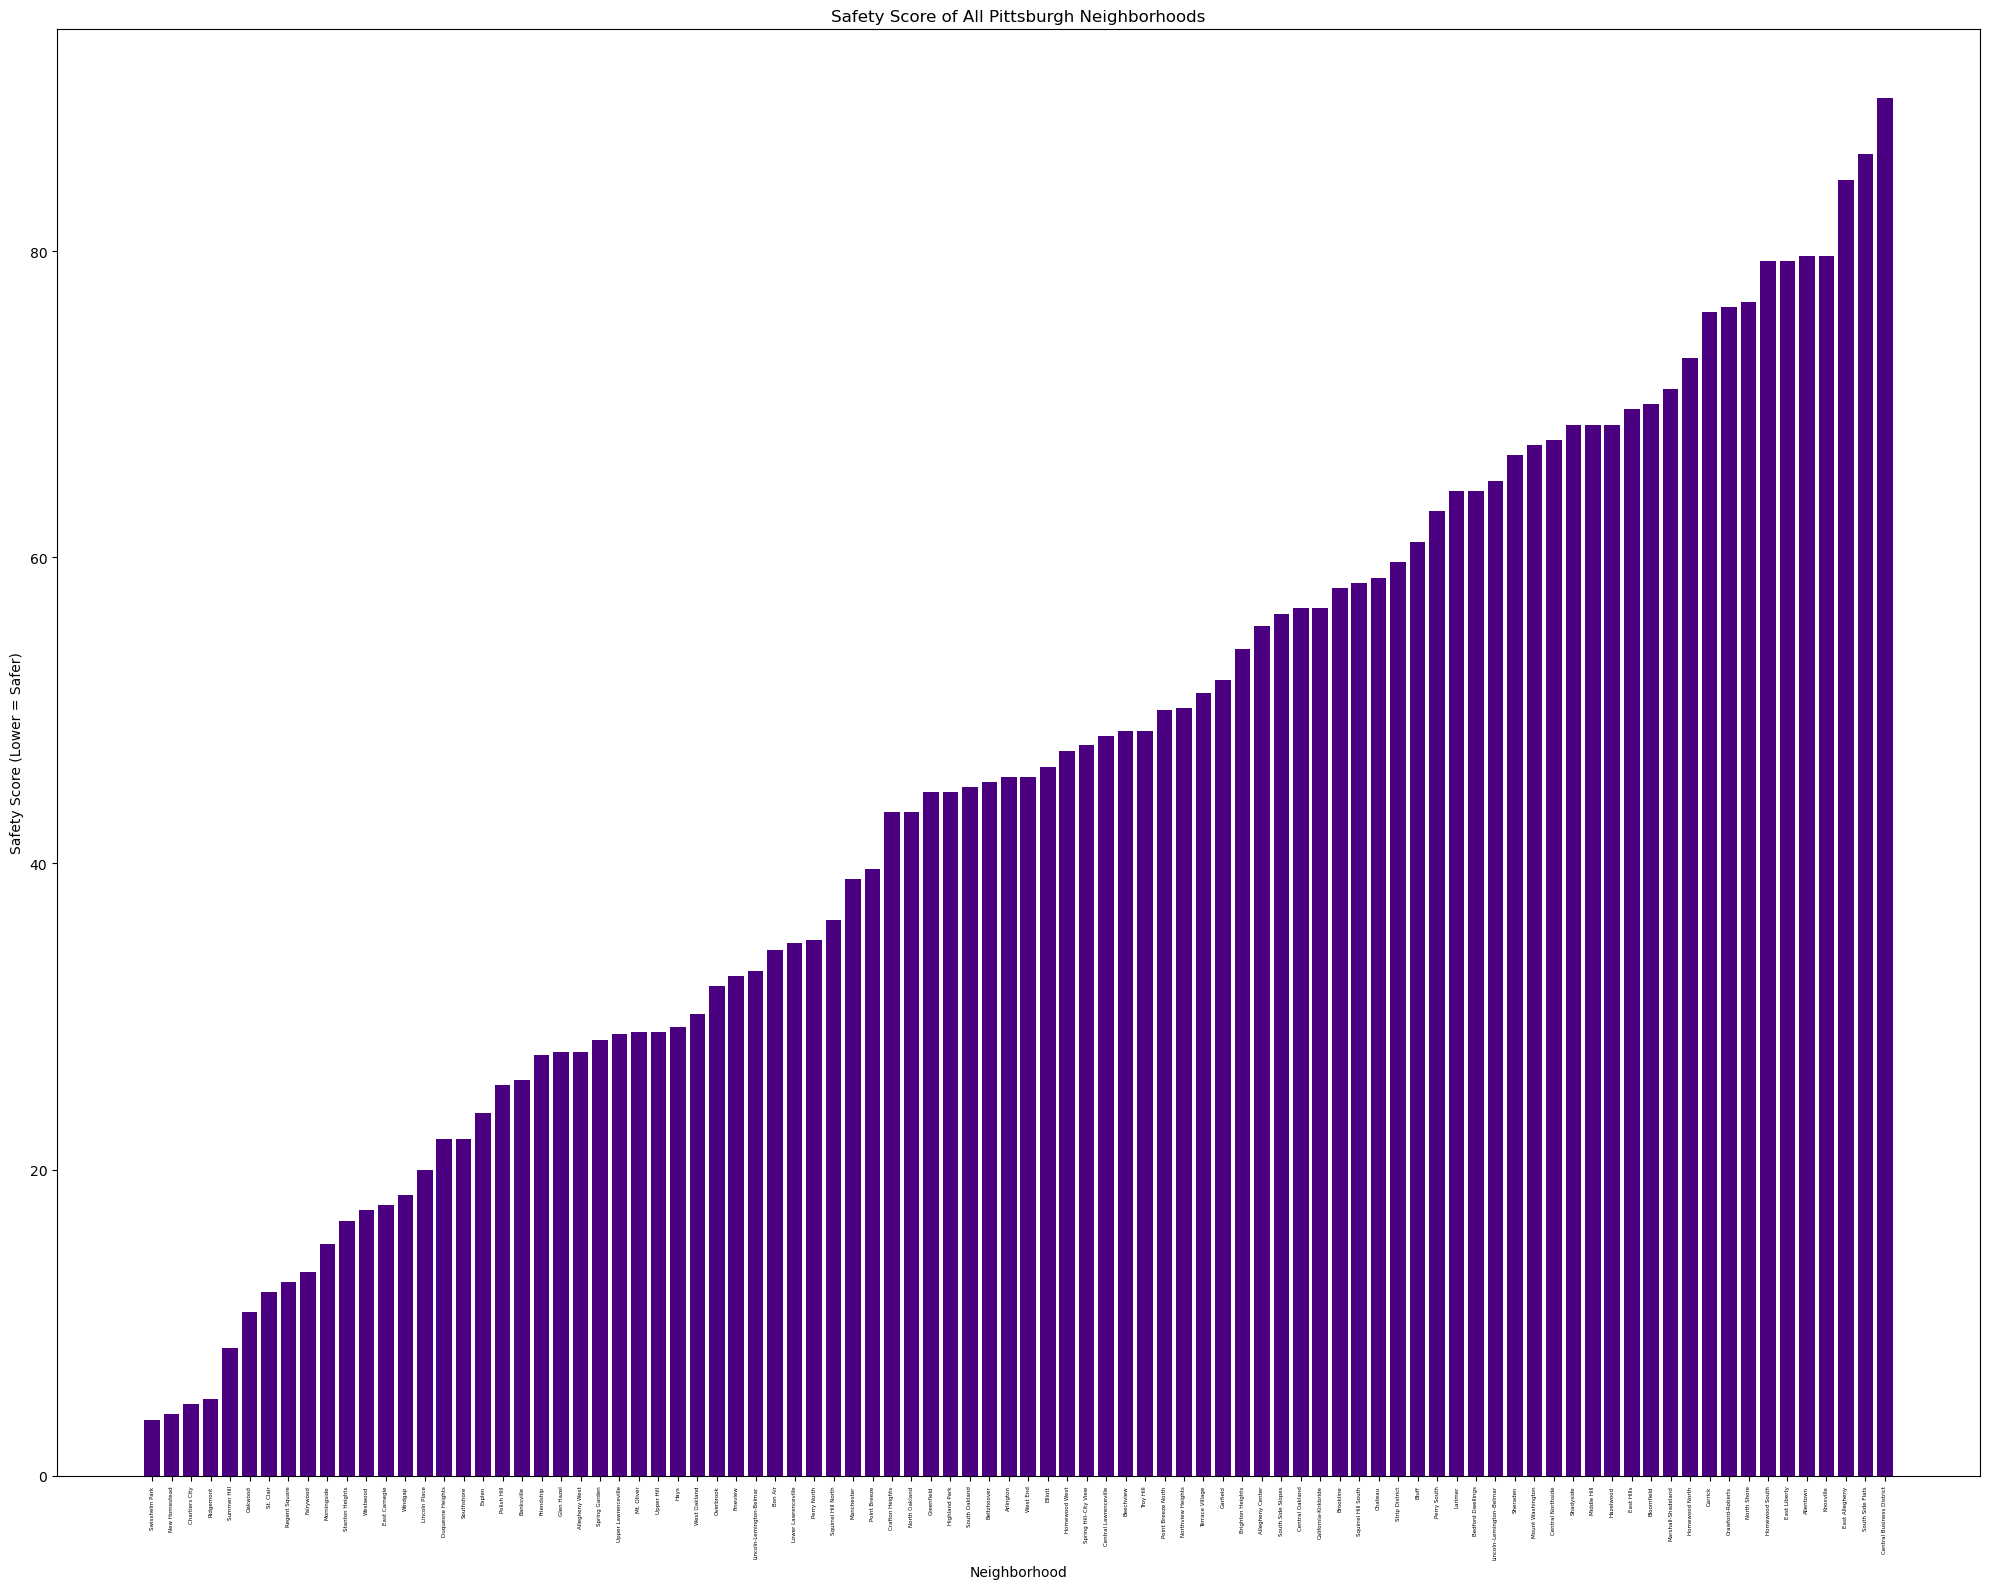

In [15]:

safety = neigh_full.sort_values('Safety_Score', ascending=True)

plt.figure(figsize=(20, 16))
plt.bar(safety['Neighborhood'], safety['Safety_Score'], color ="indigo")

plt.xticks(rotation=90, fontsize=4)  # small font so all labels fit
plt.xlabel("Neighborhood")
plt.ylabel("Safety Score (Lower = Safer)")
plt.title("Safety Score of All Pittsburgh Neighborhoods")

plt.tight_layout()
plt.show()

This bar graph is a demonstration of the data used to get a "safety" score for each Neighborhood. This submetric has its own submetrics, which are then ranked to get the safety score of each neighborhood, with the **lower** safety scores being a **higher** ranking, thus lower safety score = safer.

Here's a look at the top 20 within this submetric

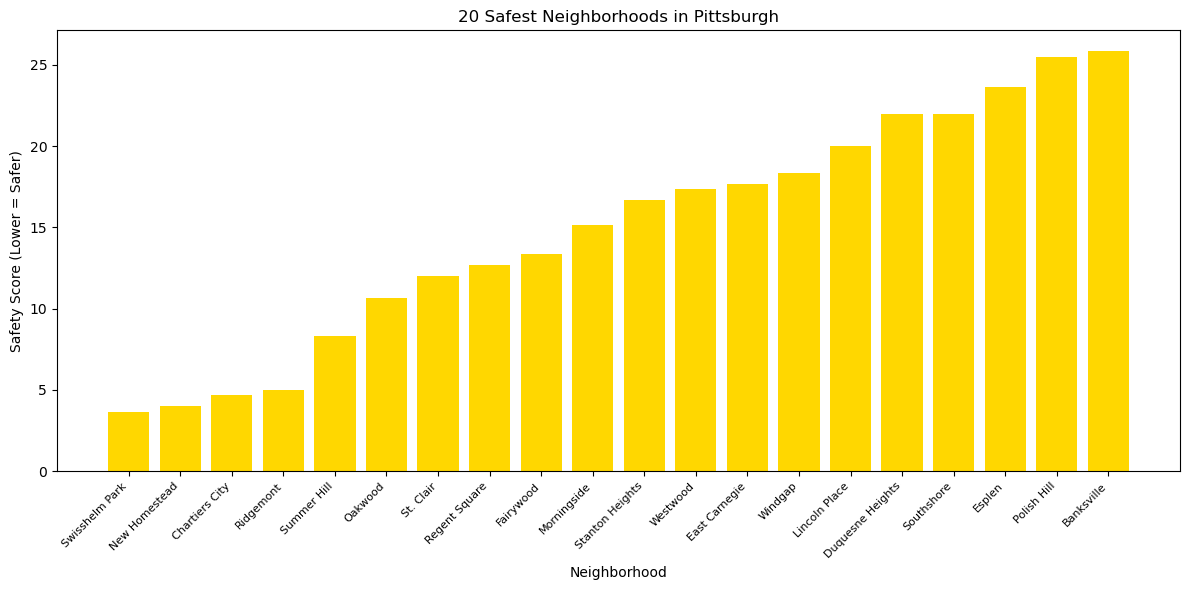

In [18]:
afety = neigh_full.sort_values('Safety_Score', ascending=True)

# Select the 20 safest
safest20 = safety.head(20)

plt.figure(figsize=(12, 6))
plt.bar(safest20['Neighborhood'], safest20['Safety_Score'], color="gold")

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel("Neighborhood")
plt.ylabel("Safety Score (Lower = Safer)")
plt.title("20 Safest Neighborhoods in Pittsburgh")

plt.tight_layout()
plt.show()

Right now this would put Swisshelm in first place with a total metric score of 10. The runners up are New Homestead and Chartiers City.

## **Do Not Replace -Tredon**

In [26]:
safety_sorted = neigh_full.sort_values('Safety_Score', ascending=True).reset_index(drop=True)

n = len(safety_sorted)
safety_sorted['Score'] = 1 - (np.arange(n) / (n - 1)) * (1 - 0.1)

submetric1 = safety_sorted[['Neighborhood', 'Score']]
submetric1.head(10)

,Neighborhood,Score
0,Swisshelm Park,1.000000
1,New Homestead,0.989888
2,Chartiers City,0.979775
3,Ridgemont,0.969663
4,Summer Hill,0.959551
5,Oakwood,0.949438
6,St. Clair,0.939326
7,Regent Square,0.929213
8,Fairywood,0.919101
9,Morningside,0.908989


Now that submetric 1 is complete, this can form a base for the metric we're using to get the best neighborhood. This code creates the dataset we'll use to store totals. Provided is also the top 10 in another format showing the totals.

In [30]:
best_neighborhood = submetric1.copy()
best_neighborhood['Total'] = best_neighborhood['Score'] * 10

# Sort by the new metric descending and show top 10
top10 = best_neighborhood.sort_values('Total', ascending=False).head(10)

print(top10[['Neighborhood', 'Total']])

     Neighborhood      Total
0  Swisshelm Park  10.000000
1   New Homestead   9.898876
2  Chartiers City   9.797753
3       Ridgemont   9.696629
4     Summer Hill   9.595506
5         Oakwood   9.494382
6       St. Clair   9.393258
7   Regent Square   9.292135
8       Fairywood   9.191011
9     Morningside   9.089888
